## 环境搭建

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import ylearn
from ylearn.causal_discovery import CausalDiscovery

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
np.random.seed(2022)

In [3]:
# replace nan
def build_data(train):
    train_ = {}
    for i in train.columns:
        train_i = train[i]
        if any(train[i].isna()):
            train_i = train_i.replace(np.nan, train[i].mean())
        if len(train_i.value_counts()) <= 20 and train_i.dtype != object:
            train_i = train_i.astype(int)
        train_[i] = train_i

    return pd.DataFrame(train_)

# save data and their corresponding transformers
class TransData:
    def __init__(self, name, is_obj=False):
        self.is_obj = is_obj
        self.name = name
        self.transformer = None

    def __call__(self, data):
        self.df = data[self.name]
        series = self.df.to_numpy().reshape(-1, 1)
        if self.df.dtype == object:
            self.is_obj = True
            self.transformer = OrdinalEncoder()
            self.data = self.transformer.fit_transform(series).astype(int)
        elif self.df.dtype != int:
            self.transformer = StandardScaler()
            self.data = self.transformer.fit_transform(series)
        else:
            self.data = series

## 数据读取

In [4]:
train = pd.read_csv('../../data/train.csv')
test = pd.read_csv('../../data/test.csv')

train = build_data(train)
test = build_data(test)

In [5]:
train.shape, test.shape

((36188, 42), (5000, 40))

In [6]:
train.head()
test.head()

,V_0,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,...,V_32,V_33,V_34,V_35,V_36,V_37,V_38,V_39,treatment,outcome
0,1.778505,2.376919,0.0,-1.680176,-1.581142,0,-31.4,0.838,no,3,...,36.710780,5.438752,-1.269324,6.026618,53,-2,0,3,2,4.745129
1,-0.631728,5.337631,0.0,-0.869348,-2.767838,0,-42.0,4.120,no,999,...,32.913967,3.478513,3.309444,3.011011,50,0,2,4,0,7.310963
2,-0.862595,3.215953,1.0,-1.614799,-2.614270,1,-41.8,4.866,no,999,...,-201.735840,1.514067,-5.461385,4.281093,37,1,1,2,2,-52.156193
3,0.230854,2.250193,0.0,-1.631994,-5.705525,1,-36.1,4.966,no,999,...,-69.010270,3.073917,3.285422,3.228095,35,1,0,3,0,-17.011566
4,0.194774,4.896442,0.0,-0.143322,2.568728,1,-42.7,4.968,no,999,...,-46.994690,2.903061,-1.614107,4.383740,58,1,0,2,2,-15.229788


,V_0,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,...,V_30,V_31,V_32,V_33,V_34,V_35,V_36,V_37,V_38,V_39
0,1.013263,7.153845,0.0,0.518550,2.912378,2,-46.2,1.281,no,999,...,-69.169106,6,89.354300,1.769277,-8.957970,4.821812,28,-1,1,4
1,1.256475,3.337584,1.0,0.719682,1.062356,1,-41.8,4.961,no,999,...,62.006910,4,-47.296772,4.304446,1.644096,3.086659,39,1,0,3
2,0.328848,3.779895,0.0,0.599383,0.858129,2,-36.1,4.964,no,999,...,102.485540,1,-103.987030,2.712243,0.901617,1.579955,33,1,0,4
3,-0.155332,2.034172,0.0,2.667294,2.557145,1,-36.1,4.963,no,999,...,87.844505,1,-85.620186,2.461733,1.008162,-1.084060,41,1,0,1
4,-1.144003,2.884787,0.0,-0.486087,4.241822,2,-36.1,4.965,no,999,...,198.070620,1,-203.561700,2.403087,-1.649364,3.734623,30,1,0,1


## V-X模型

### 数据划分

In [7]:
from sklearn.model_selection import train_test_split

Y = train.treatment
X = train.drop(['treatment', 'outcome'], axis=1)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.3, random_state=42)

In [8]:
Xtrain.shape, Xval.shape, Ytrain.shape, Yval.shape

((25331, 40), (10857, 40), (25331,), (10857,))

### 预处理

In [9]:
def preprocess(train, test):
    data_dict = {}
    cat_name = []
    test_dict = {}
    for name in train.columns:
        t = TransData(name=name)
        t(train)
        data_dict[name] = t.data.reshape(-1, )
        if t.is_obj:
            cat_name.append(name)
        if name not in ['treatment', 'outcome']:
            try:
                test_i = t.transformer.transform(test[name].values.reshape(-1, 1)).reshape(-1, )
            except:
                test_i = test[name]
            test_dict[name] = test_i
    return data_dict, test_dict, cat_name

data_dict, val_dict, cat_name = preprocess(Xtrain, Xval)
train_data = pd.DataFrame(data_dict)
val_data = pd.DataFrame(val_dict)

### 模型搭建

In [10]:
vx_model = RandomForestClassifier(n_estimators=150, criterion='entropy', max_features=0.5, max_depth=50)
vx_model.fit(train_data, Ytrain)
vx_model.score(train_data, Ytrain)
vx_model.score(val_data, Yval)

RandomForestClassifier(criterion='entropy', max_depth=50, max_features=0.5,
                       n_estimators=150)

1.0

0.9318412084369532

In [11]:
vx_importance = pd.DataFrame({'feature': list(train_data.columns), 'importance': vx_model.feature_importances_}) 
vx_importance

,feature,importance
0,V_0,0.010892
1,V_1,0.128700
2,V_2,0.103529
3,V_3,0.025000
4,V_4,0.007583
5,V_5,0.001742
6,V_6,0.004940
7,V_7,0.010327
8,V_8,0.000824
9,V_9,0.000785


## VX-Y模型

### 数据划分

In [12]:
from sklearn.model_selection import train_test_split

Y = train.outcome
X = train.drop(['outcome'], axis=1)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.3, random_state=42)

In [13]:
Xtrain.shape, Xval.shape, Ytrain.shape, Yval.shape

((25331, 41), (10857, 41), (25331,), (10857,))

### 预处理

In [14]:
def preprocess(train, test):
    data_dict = {}
    cat_name = []
    test_dict = {}
    for name in train.columns:
        t = TransData(name=name)
        t(train)
        data_dict[name] = t.data.reshape(-1, )
        if t.is_obj:
            cat_name.append(name)
        if name not in ['outcome']:
            try:
                test_i = t.transformer.transform(test[name].values.reshape(-1, 1)).reshape(-1, )
            except:
                test_i = test[name]
            test_dict[name] = test_i
    return data_dict, test_dict, cat_name

data_dict, val_dict, cat_name = preprocess(Xtrain, Xval)
train_data = pd.DataFrame(data_dict)
val_data = pd.DataFrame(val_dict)

In [15]:
train_data.shape, val_data.shape

((25331, 41), (10857, 41))

### 模型搭建

In [16]:
vxy_model = RandomForestRegressor(n_estimators=150, max_features=0.5, max_depth=100)
vxy_model.fit(train_data, Ytrain)
vxy_model.score(train_data, Ytrain)
vxy_model.score(val_data, Yval)

RandomForestRegressor(max_depth=100, max_features=0.5, n_estimators=150)

0.9983910155384316

0.9886609944563354

In [17]:
vxy_importance = pd.DataFrame({'feature': list(train_data.columns), 'importance': vxy_model.feature_importances_}) 
vxy_importance

,feature,importance
0,V_0,0.000426
1,V_1,0.000627
2,V_2,0.002174
3,V_3,0.000790
4,V_4,0.001111
5,V_5,0.000056
6,V_6,0.000110
7,V_7,0.002189
8,V_8,0.000398
9,V_9,0.001037


## 绘制图片

In [18]:
from matplotlib import pyplot as plt

# plt.style.available
plt.style.use("seaborn")  # 更改绘图主题  主要是一些自定义样式更改
# windows电脑 Matplotlib 支持中文
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

<AxesSubplot:ylabel='feature'>

Text(0.5, 1.0, 'V-X model')

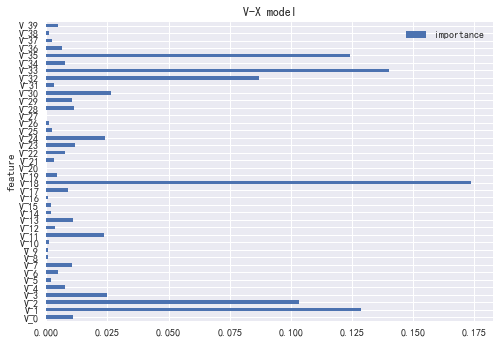

In [19]:
vx_importance.set_index(["feature"]).plot.barh(stacked=True)
plt.legend(loc='upper right')
plt.title('V-X model')

<AxesSubplot:ylabel='feature'>

Text(0.5, 1.0, 'VX-Y model')

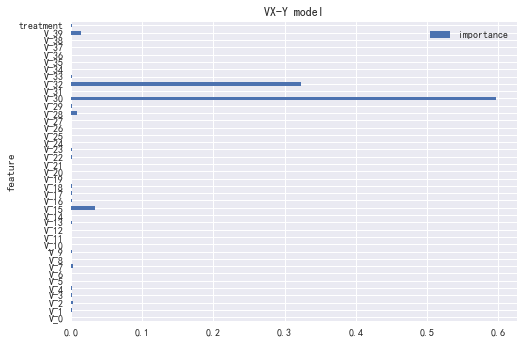

In [20]:
vxy_importance.set_index(["feature"]).plot.barh(stacked=True)
plt.legend(loc='upper right')
plt.title('VX-Y model')

## 混淆因子

In [21]:
all_importance = pd.merge(vx_importance, vxy_importance, on='feature')
all_importance

,feature,importance_x,importance_y
0,V_0,0.010892,0.000426
1,V_1,0.128700,0.000627
2,V_2,0.103529,0.002174
3,V_3,0.025000,0.000790
4,V_4,0.007583,0.001111
5,V_5,0.001742,0.000056
6,V_6,0.004940,0.000110
7,V_7,0.010327,0.002189
8,V_8,0.000824,0.000398
9,V_9,0.000785,0.001037


In [23]:
confounder = all_importance.query(f"importance_x >= 1e-3 and importance_y >= 1e-5")
confounder

,feature,importance_x,importance_y
0,V_0,0.010892,0.000426
1,V_1,0.128700,0.000627
2,V_2,0.103529,0.002174
3,V_3,0.025000,0.000790
4,V_4,0.007583,0.001111
5,V_5,0.001742,0.000056
6,V_6,0.004940,0.000110
7,V_7,0.010327,0.002189
10,V_10,0.001166,0.000058
11,V_11,0.023430,0.000419


In [24]:
non_confounder = set(all_importance['feature']) - set(confounder['feature'])
non_confounder

{'V_16', 'V_20', 'V_27', 'V_8', 'V_9'}